## Diagrama de Autoencoder Variacional
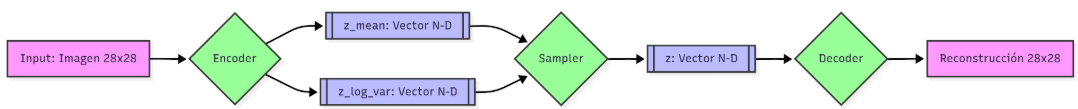

## Define el codificador
El bloque decodificador utiliza capas convolucionales para extraer características.
Aplana las características y las pasa por una capa densa. Produce dos salidas: z_mean y z_log_var, que representan la media y el logaritmo de la varianza del espacio latente.

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [4]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Define funcion de muestreo
Utiliza z_mean y z_log_var para generar muestras del espacio latente e implementa una reparametrización para permitir el entrenamiento mediante retropropagación.

In [5]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Define el bloque decodificador

El bloque decodificador toma muestras del espacio latente como entrada.
Utiliza capas densas y convolucionales transpuestas para reconstruir la imagen original.

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [7]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

## Define el paso de entrenamiento y las metricas utilizando una clase
El autonecoder variable combina el codificador, decodificador y muestreador.
Implementa la lógica de entrenamiento en el método train_step.
Calcula dos tipos de pérdidas:

a. **Pérdida de reconstrucción**: Cuantifica la capacidad del modelo para reconstruir fielmente los datos de entrada.

b. **Pérdida KL (Kullback-Leibler Divergence)**: Cuantifica la divergencia entre la distribución latente y una distribución normal estándar.

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):

        with tf.GradientTape() as tape: # GradientTape para registrar las operaciones para la diferenciación automática

            z_mean, z_log_var = self.encoder(data) # Codifica entrada y obtiene media y log-varianza del espacio latente

            z = self.sampler(z_mean, z_log_var)    # Muestrea del espacio latente usando reparametrización

            reconstruction = decoder(z)            # Reconstruye la entrada usando el decoder

            # Calcula la pérdida de reconstrucción (binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # Calcula Kullback-Leibler divergence
            kl_loss = tf.reduce_mean(kl_loss)
            total_loss = reconstruction_loss + kl_loss # Combina y obtiene pérdida total

        grads = tape.gradient(total_loss, self.trainable_weights)  # Calcula los gradientes

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))  # Aplica gradientes para actualizar los pesos

        # Actualiza las métricas de pérdida
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        # Retorna diccionario con los valores de las métricas
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Entrenar el modelo con MNIST

In [9]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 34s 56ms/step - total_loss: 208.0985 - reconstruction_loss: 206.8661 - kl_loss: 1.2325
Epoch 2/30
547/547 [==============================] - 31s 56ms/step - total_loss: 170.4665 - reconstruction_loss: 168.0733 - kl_loss: 2.3931
Epoch 3/30
547/547 [==============================] - 41s 75ms/step - total_loss: 159.3361 - reconstruction_loss: 156.4171 - kl_loss: 2.9190
Epoch 4/30
547/547 [==============================] - 49s 89ms/step - total_loss: 156.1326 - reconstruction_loss: 153.0516 - kl_loss: 3.0811
Epoch 5/30
547/547 [==============================] - 48s 89ms/step - total_loss: 154.5051 - reconstruction_loss: 151.3416 - kl_loss: 3.1635
Epoch 6/30
547/547 [==============================] - 50s 91ms/step - total_loss: 153.2502 - reconstruction_loss: 150.0239 - kl_loss: 3.2263
Epoch 7/30
547/547 [==============================] - 51s 93ms/step - total_loss: 152.3822 - reconstruction_loss: 149.1203 - kl_loss: 3.2619
Epoch 8/30
54

**Sampling a grid of images from the 2D latent space**

 29 - 29    

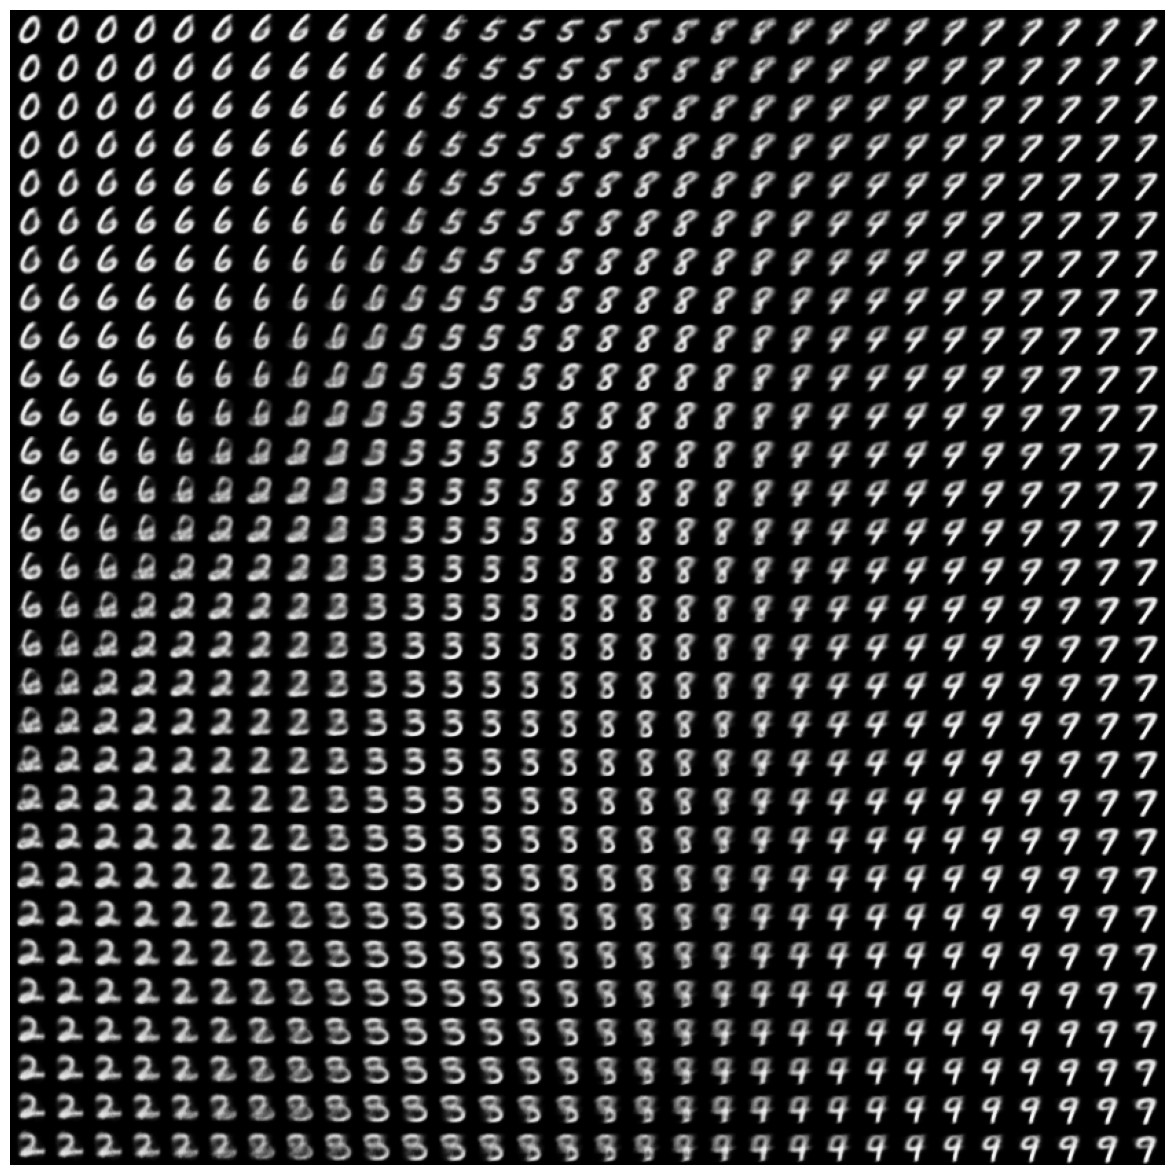

In [15]:
import matplotlib.pyplot as plt

n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        print('\r Generando imagenes (%d, %d)     ' % (i,j),end='')
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

### Wrapping up

In [11]:
z_sample


array([[ 1., -1.]])

1/1 [==============================] - 0s 46ms/step


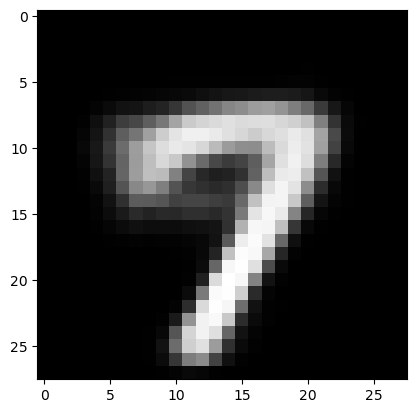

In [12]:
x_decoded = vae.decoder.predict([[1, -0.5]])
digit = x_decoded[0].reshape(digit_size, digit_size)
plt.imshow(digit, cmap="Greys_r")